In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
from mceq2d_dists import MCEQDist2D, CalcMCEqHists


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.dpi"] = 100

In [12]:
from pathlib import Path
corsika_data_file = "16_corsika_data/proton_run_16.h5"

dir_for_figures = Path("/hetghome/antonpr/xmax_sigma/flincpy/scripts/")
dir_for_figures = dir_for_figures/"plots/11_mceq2d_comp"

# Create path if it doesn't exist
Path(dir_for_figures).mkdir(parents=True, exist_ok=True)

# MCEq initialization calculations

In [5]:
mceq_sol = MCEQDist2D(
                 energy = 100,
                 pdg_id = 2212,
                 theta_deg = 30,
                 # corresponds to X = 143, 647, 1033 g/cm2 for theta=0
                 slant_depths = [164.945, 746.679, 1192.3517],
                 energy_range = [1e-1, 1e4],
                 interaction_model = "DPMJETIII191", 
                 hybrid_crossover = 0.1,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


100%|██████████| 2744/2744 [00:19<00:00, 141.00it/s]


In [6]:
mceq_dists = CalcMCEqHists(mceq_sol, particles = [12, 13, 14])

# Fluka initialization

In [7]:
from pathlib import Path
import sys
scripts_dir = Path("/hetghome/antonpr/xmax_sigma/flincpy/scripts")
sys.path.insert(0, str(scripts_dir/"fluka_comparison"))
from read_fluka_data import fluka_histogram, fluka_histogram_en

In [8]:
# Fluka energy distributions
fluka_hist_en = {}
for label in ("current", "develop"):
    fluka_hist_en[label] = fluka_histogram_en(label, 0)
    
fluka_energy_bins_en = fluka_hist_en["current"][0][0]

In [9]:
# Fluka angular distributions
fluka_ang_bin_merge_level = 0
fluka_hist = {}
for label in ("current", "develop"):
    fluka_hist[label] = fluka_histogram(label, fluka_ang_bin_merge_level)
    
fluka_ang_bins = fluka_hist["current"][0][0][0]   

# Corsika intializatioin

In [10]:
import sys
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy/scripts/corsika_flincpy")
from corsika_comparison import (corsika_hist_en, combined_data_en, 
                                 corsika_en_theta_2dhist,
                                 combined_ang_data)

In [13]:
# Corsika energy distributions
chist_en = corsika_hist_en(fluka_energy_bins_en, 
                           h5file=corsika_data_file)

proton_run_16.h5: Number of primaries = 3.000000e+06


In [14]:
# Take a sum of particles
corsika_en_dist = {}
for i in range(3):
    corsika_en_dist[i]  = combined_data_en(chist_en, [-13, 13], i)

In [15]:
# Corsika angular distributions
# energy_bins = [1, 1.25892541, 1.99526231,  2.51188643,  3.98107171, 5.01187234]
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
ang_bins = fluka_ang_bins
corsika_en_hist = corsika_en_theta_2dhist(energy_bins, 
                                          fluka_ang_bins,
                                          h5file=corsika_data_file)

corsika_comb_mu = combined_ang_data(corsika_en_hist, (-13, 13))
corsika_comb_nue = combined_ang_data(corsika_en_hist, (-12, 12))
corsika_comb_numu = combined_ang_data(corsika_en_hist, (-14, 14))

pdg = -12
xdepth=124.0, number=2.7668e+06
xdepth=552.0, number=6.6167e+06
xdepth=1036.0, number=7.3449e+06
pdg = 12
xdepth=124.0, number=3.0021e+06
xdepth=552.0, number=7.1454e+06
xdepth=1036.0, number=7.9474e+06
pdg = -13
xdepth=124.0, number=6.9842e+06
xdepth=552.0, number=5.7947e+06
xdepth=1036.0, number=3.5412e+06
pdg = 13
xdepth=124.0, number=6.2724e+06
xdepth=552.0, number=5.1226e+06
xdepth=1036.0, number=2.9921e+06
pdg = -14
xdepth=124.0, number=9.7036e+06
xdepth=552.0, number=1.8556e+07
xdepth=1036.0, number=1.9481e+07
pdg = 14
xdepth=124.0, number=1.0419e+07
xdepth=552.0, number=1.9426e+07
xdepth=1036.0, number=2.0283e+07


# Energy spectra comparisons

In [16]:
params = {'mathtext.default': 'regular',
          'text.usetex': False}          
plt.rcParams.update(params)
figure_format = "svg"

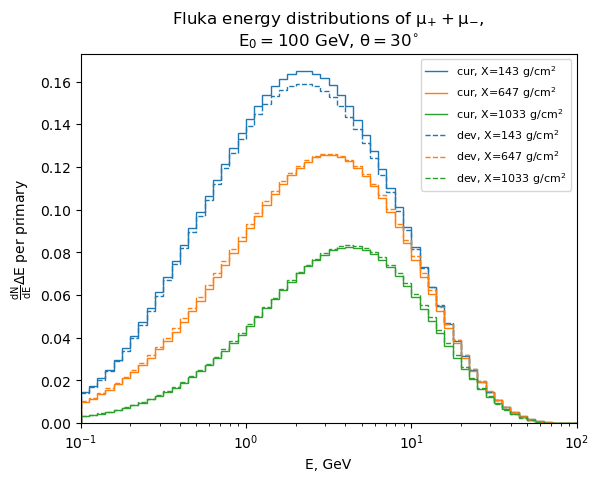

In [17]:
# Fluka energy distributions
figure_name = f"fig01.{figure_format}"
line_colors = []
for ixdepth in range(3):
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    line = plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"cur, X={fl_hist_en[3]} " + r"$g/cm^2$")
    line_colors.append(line.get_edgecolor())
    
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["develop"][ixdepth]
    line = plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"dev, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")

plt.xscale("log")
plt.xlim(1e-1, 1e2)
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(loc = "upper right", fontsize = "8")   
plt.title(r"Fluka energy distributions of $\mu_{+} + \mu_{-}$, " + "\n" + r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

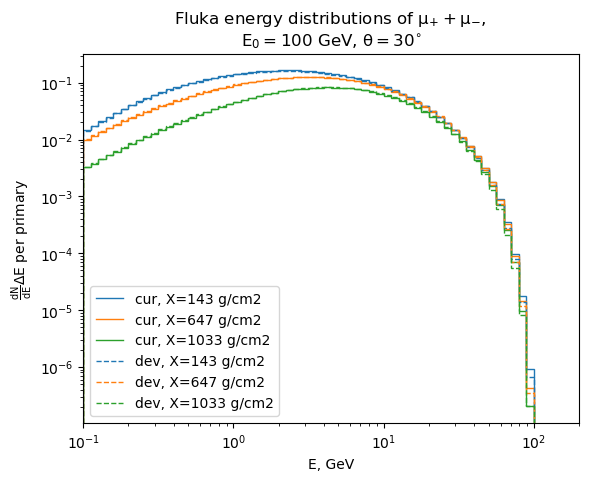

In [18]:
# Fluka energy distributions

figure_name = f"fig02.{figure_format}"
line_colors = []
for ixdepth in range(3):
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    line = plt.stairs(fl_hist_en[1], fl_hist_en[0], label = f"cur, X={fl_hist_en[3]} g/cm2")
    line_colors.append(line.get_edgecolor())

for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["develop"][ixdepth]
    line = plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"dev, X={fl_hist_en[3]} g/cm2",
                      color = line_colors[ixdepth],
                      linestyle = "--")

plt.xscale("log")
plt.xlim(1e-1, 2e2)
plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(loc = "lower left")   
plt.title(r"Fluka energy distributions of $\mu_{+} + \mu_{-}$, " + "\n" + r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

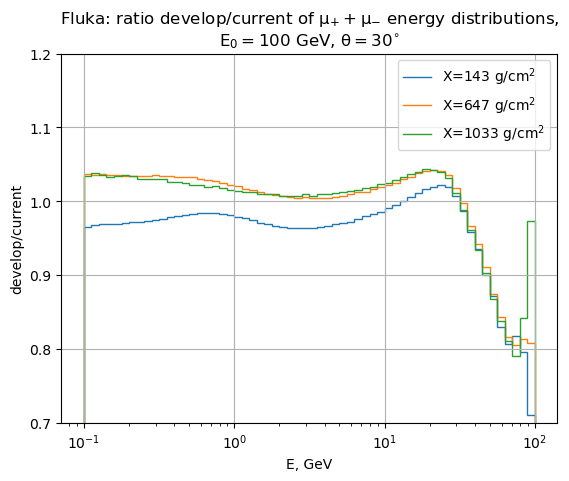

In [19]:
figure_name = f"fig03.{figure_format}"
for ixdepth in range(3):
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    # line = plt.stairs(fl_hist_en[1], fl_hist_en[0], label = f"fl:current X={fl_hist_en[3]} g/cm2")
    
    fl_hist_en1 = fluka_hist_en["develop"][ixdepth]
    plt.stairs(fl_hist_en1[1]/fl_hist_en[1], fl_hist_en1[0], 
                      label = f"X={fl_hist_en[3]} " + r"$g/cm^2$",
                    #   color = line.get_edgecolor(),
                    #   linestyle = "--"
                      )

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylim(0.7, 1.2)
plt.ylabel(r"develop/current")
plt.legend()   
plt.grid()
plt.title(r"Fluka: ratio develop/current of $\mu_{+} + \mu_{-}$ energy distributions," + "\n" + r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

# Fluka vs MCEq vs Corsika comparison

In [20]:
# Integrate over angles
angle_bins = np.deg2rad(np.linspace(0, 90, 2))
energy_bins = fluka_energy_bins_en
mceq_hists_en = mceq_dists.histograms(energy_bins, angle_bins)

  0%|          | 0/3 [00:00<?, ?it/s]

Particle 12, slant depth = 164.945
Particle 12, slant depth = 746.679
Particle 12, slant depth = 1192.3517


 33%|███▎      | 1/3 [00:09<00:19,  9.54s/it]

Particle 13, slant depth = 164.945


/hetghome/antonpr/miniconda3/envs/env_impy/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Particle 13, slant depth = 746.679
Particle 13, slant depth = 1192.3517


 67%|██████▋   | 2/3 [00:21<00:10, 10.95s/it]

Particle 14, slant depth = 164.945
Particle 14, slant depth = 746.679
Particle 14, slant depth = 1192.3517


100%|██████████| 3/3 [00:42<00:00, 14.12s/it]


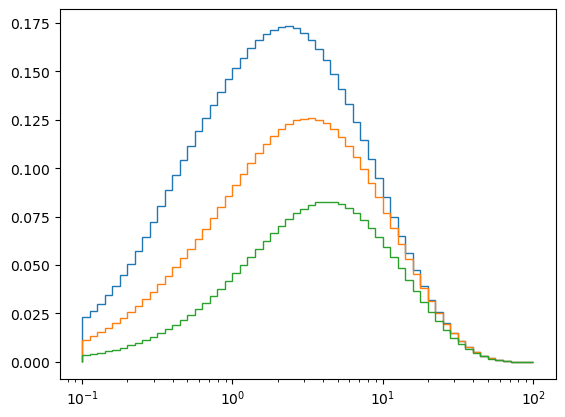

In [22]:
# Test plot
for ixdepth in range(3):
    plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
                mceq_hists_en[13][ixdepth]["en_bins"])
        
plt.xscale("log")  

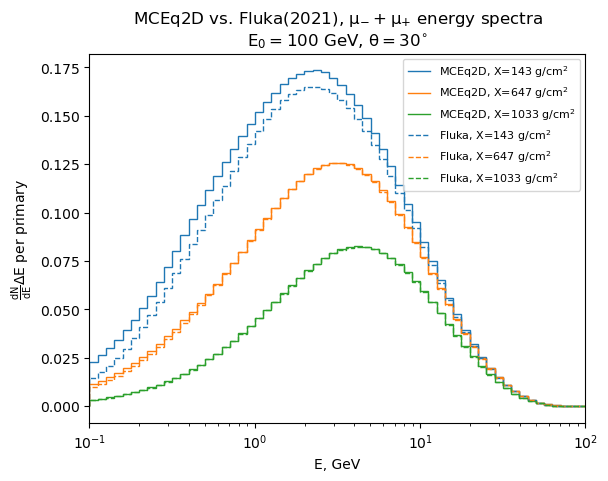

In [23]:

figure_name = f"fig04.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []
for ixdepth in range(3):
    
    line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
            mceq_hists_en[13][ixdepth]["en_bins"], 
            label = f"MCEq2D, X={xdepth_list[ixdepth]} " + r"$g/cm^2$",
            # color = line.get_edgecolor(),
                #   linestyle = "--"
                    )
    line_colors.append(line.get_edgecolor())
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"Fluka, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")

    

plt.xscale("log")
plt.xlim(1e-1, 1e2)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Fluka(2021), $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

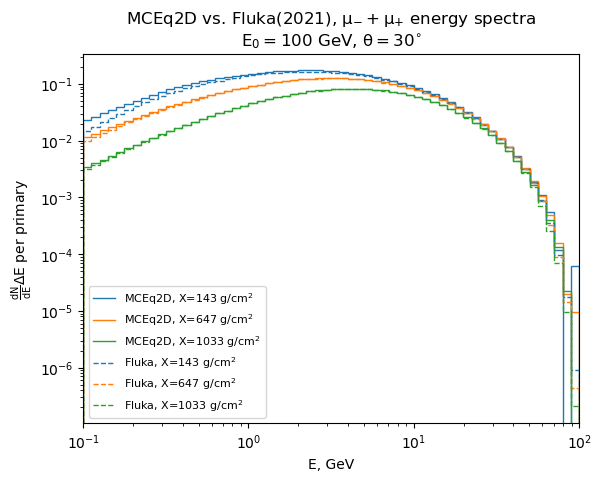

In [24]:

figure_name = f"fig05.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []
for ixdepth in range(3):
    
    line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
            mceq_hists_en[13][ixdepth]["en_bins"], 
            label = f"MCEq2D, X={xdepth_list[ixdepth]} " + r"$g/cm^2$",
            # color = line.get_edgecolor(),
                #   linestyle = "--"
                    )
    line_colors.append(line.get_edgecolor())
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"Fluka, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")

    
plt.xscale("log")
plt.xlim(1e-1, 1e2)
plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Fluka(2021), $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

/tmp/ipykernel_531562/2613983254.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.stairs(fl_hist_en[1]/mceq_curr, fl_hist_en[0],


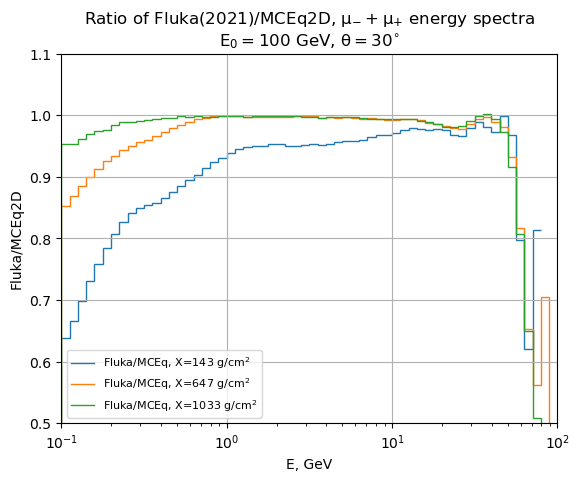

In [26]:

figure_name = f"fig06.{figure_format}"
xdepth_list = [143, 647, 1033]
line_colors = []

for ixdepth in range(3):
    mceq_curr = mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0]
    mceq_curr[mceq_curr < 0] = 0 
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1]/mceq_curr, fl_hist_en[0], 
                      label = f"Fluka/MCEq, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      )

plt.xscale("log")
plt.xlim(1e-1, 1e2)
# plt.yscale("log")
plt.grid()
plt.xlabel("E, GeV")
plt.ylim(0.5, 1.1)
plt.ylabel(r"Fluka/MCEq2D")
plt.legend(fontsize="8")   
plt.title(r"Ratio of Fluka(2021)/MCEq2D, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")


plt.savefig(dir_for_figures/figure_name)

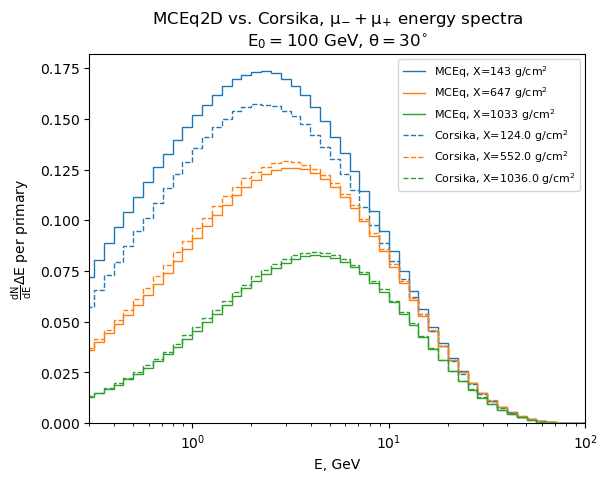

In [27]:
figure_name = f"fig07.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []

# MCEq
for ixdepth in range(3):
  line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
              mceq_hists_en[13][ixdepth]["en_bins"], 
              label = f"MCEq, X={xdepth_list[ixdepth]} " + r"$g/cm^2$")
  
  line_colors.append(line.get_edgecolor())
  
# Corsika
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    plt.stairs(fl_hist_en[0], fl_hist_en[1], 
                      label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")

plt.xscale("log")
plt.xlim(3e-1, 1e2)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Corsika, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

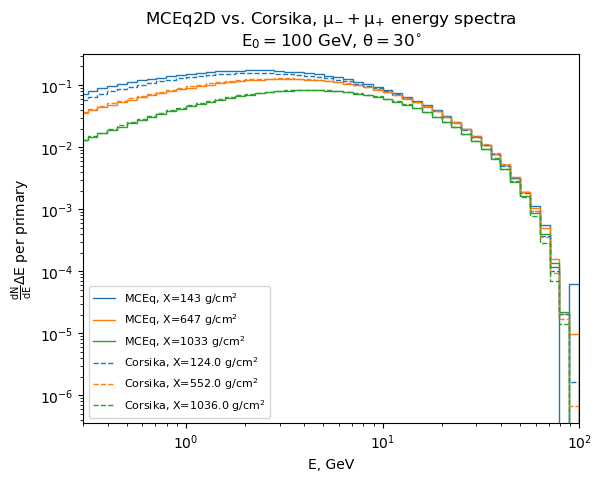

In [28]:
figure_name = f"fig08.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []

# MCEq
for ixdepth in range(3):
  line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
              mceq_hists_en[13][ixdepth]["en_bins"], 
              label = f"MCEq, X={xdepth_list[ixdepth]} " + r"$g/cm^2$")
  
  line_colors.append(line.get_edgecolor())
  
# Corsika
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    plt.stairs(fl_hist_en[0], fl_hist_en[1], 
                      label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")

plt.xscale("log")
plt.xlim(3e-1, 1e2)
plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Corsika, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

/tmp/ipykernel_531562/2341169075.py:9: RuntimeWarning: divide by zero encountered in divide
  line = plt.stairs(fl_hist_en[0]/mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
/tmp/ipykernel_531562/2341169075.py:9: RuntimeWarning: invalid value encountered in divide
  line = plt.stairs(fl_hist_en[0]/mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],


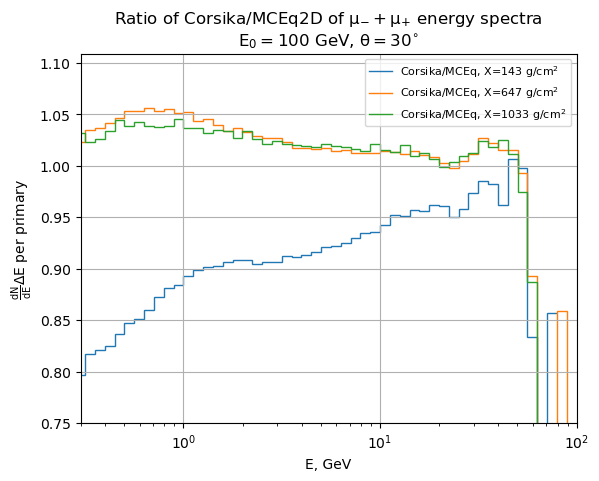

In [29]:

figure_name = f"fig09.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []

# MCEq
for ixdepth in range(3):
  fl_hist_en = corsika_en_dist[ixdepth]
  line = plt.stairs(fl_hist_en[0]/mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
              mceq_hists_en[13][ixdepth]["en_bins"], 
              label = f"Corsika/MCEq, X={xdepth_list[ixdepth]} " + r"$g/cm^2$")
  
  line_colors.append(line.get_edgecolor())
  

plt.xscale("log")
plt.xlim(3e-1, 1e2)
plt.ylim(0.75)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"Ratio of Corsika/MCEq2D of $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.grid()
plt.savefig(dir_for_figures/figure_name)

# Fluka vs Corsika

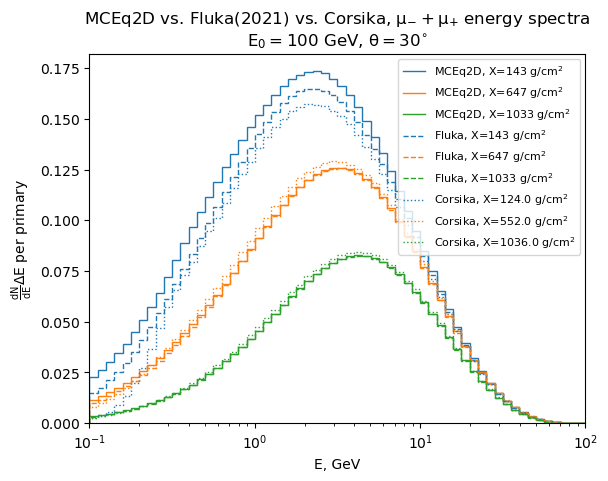

In [31]:
# for xdepth in [143, 647, 1033]:
#     plt.stairs(mceq_hists[13][xdepth]["hist_en_ang"].T[0],
#                 mceq_hists[13][xdepth]["en_bins"], label = f"MCEq, X={xdepth}")

figure_name = f"fig01_01.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []
for ixdepth in range(3):
    
    line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
            mceq_hists_en[13][ixdepth]["en_bins"], 
            label = f"MCEq2D, X={xdepth_list[ixdepth]} " + r"$g/cm^2$",
            # color = line.get_edgecolor(),
                #   linestyle = "--"
                    )
    line_colors.append(line.get_edgecolor())
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"Fluka, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")


# Corsika
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    plt.stairs(fl_hist_en[0], fl_hist_en[1], 
                      label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = ":")
    
    # fl_hist_en = corsika_en_dist[ixdepth]
    # plt.stairs(fl_hist_en[0], fl_hist_en[1], 
    #                   label = f"corsika {fl_hist_en[3]} g/cm2",
    #                   color = line.get_edgecolor(),
    #                   linestyle = ":"
    #                   )

plt.xscale("log")
plt.xlim(1e-1, 1e2)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Fluka(2021) vs. Corsika, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

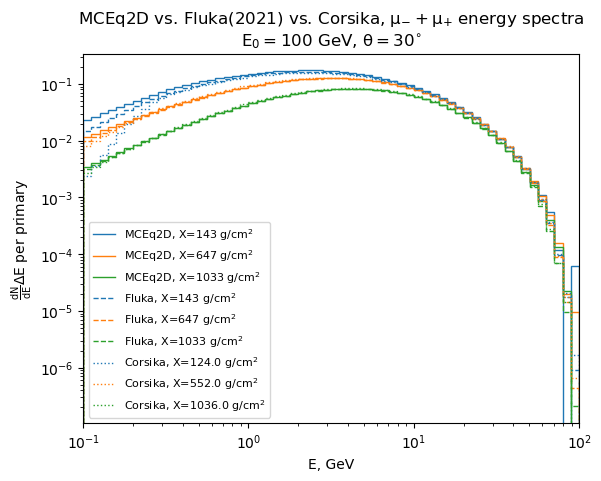

In [33]:
# for xdepth in [143, 647, 1033]:
#     plt.stairs(mceq_hists[13][xdepth]["hist_en_ang"].T[0],
#                 mceq_hists[13][xdepth]["en_bins"], label = f"MCEq, X={xdepth}")

figure_name = f"fig01_02.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []
for ixdepth in range(3):
    
    line = plt.stairs(mceq_hists_en[13][ixdepth]["hist_en_ang"].T[0],
            mceq_hists_en[13][ixdepth]["en_bins"], 
            label = f"MCEq2D, X={xdepth_list[ixdepth]} " + r"$g/cm^2$",
            # color = line.get_edgecolor(),
                #   linestyle = "--"
                    )
    line_colors.append(line.get_edgecolor())
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"Fluka, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")


# Corsika
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    plt.stairs(fl_hist_en[0], fl_hist_en[1], 
                      label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = ":")

plt.xscale("log")
plt.xlim(1e-1, 1e2)
plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Fluka(2021) vs. Corsika, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/figure_name)

/tmp/ipykernel_531562/3258440958.py:10: RuntimeWarning: divide by zero encountered in divide
  line = plt.stairs(fl_hist_en[1]/cr_hist_en[0],


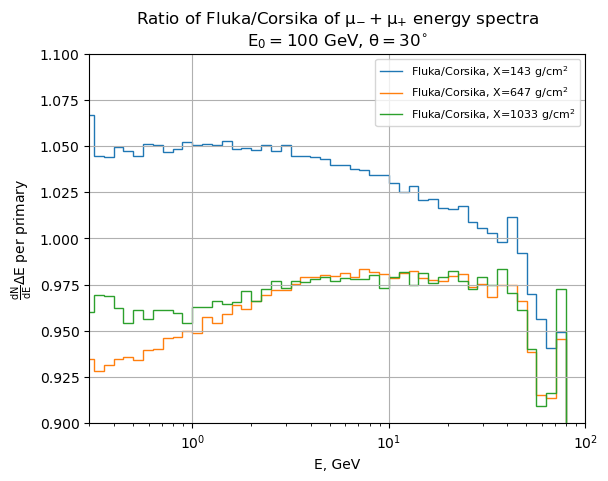

In [35]:

figure_name = f"fig01_03.{figure_format}"
xdepth_list = [143, 647, 1033]

line_colors = []

# Fluka
for ixdepth in range(3):
  cr_hist_en = corsika_en_dist[ixdepth]
  fl_hist_en = fluka_hist_en["current"][ixdepth]
  line = plt.stairs(fl_hist_en[1]/cr_hist_en[0],
              fl_hist_en[0], 
              label = f"Fluka/Corsika, X={xdepth_list[ixdepth]} " + r"$g/cm^2$")
  
  line_colors.append(line.get_edgecolor())

plt.xscale("log")
plt.xlim(3e-1, 1e2)
plt.ylim(0.9, 1.1)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"Ratio of Fluka/Corsika of $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.grid()
plt.savefig(dir_for_figures/figure_name)

# Anglular distributions

In [37]:
# Get MCEq histogram
angle_bins = fluka_ang_bins
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang = mceq_dists.histograms(energy_bins, angle_bins)

  0%|          | 0/3 [00:00<?, ?it/s]

Particle 12, slant depth = 164.945
Particle 12, slant depth = 746.679
Particle 12, slant depth = 1192.3517


 33%|███▎      | 1/3 [00:05<00:10,  5.32s/it]

Particle 13, slant depth = 164.945
Particle 13, slant depth = 746.679
Particle 13, slant depth = 1192.3517


 67%|██████▋   | 2/3 [00:09<00:04,  4.67s/it]

Particle 14, slant depth = 164.945
Particle 14, slant depth = 746.679
Particle 14, slant depth = 1192.3517


100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


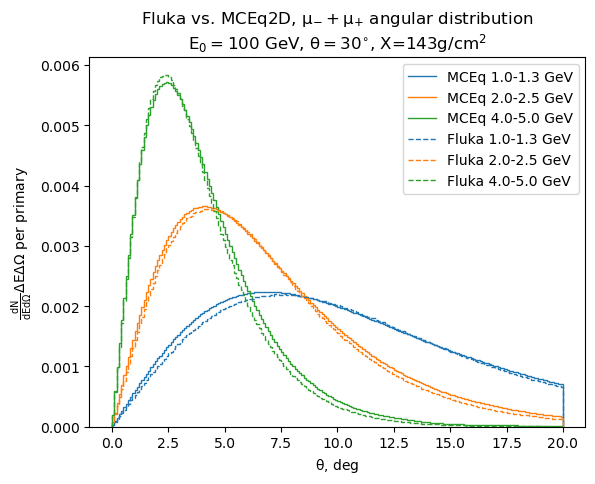

In [38]:

figure_name = f"fig10.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

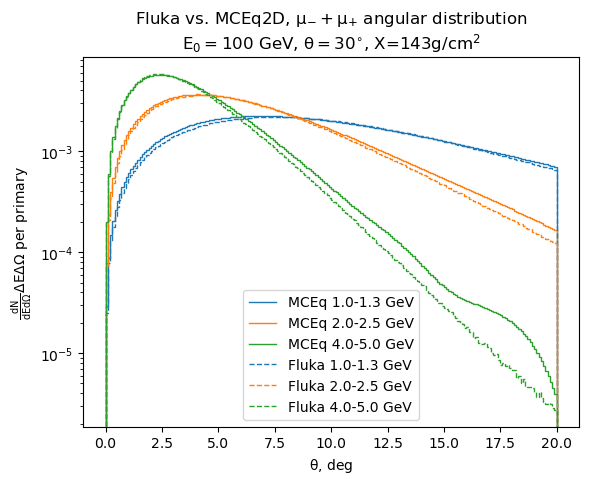

In [39]:
figure_name = f"fig11.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

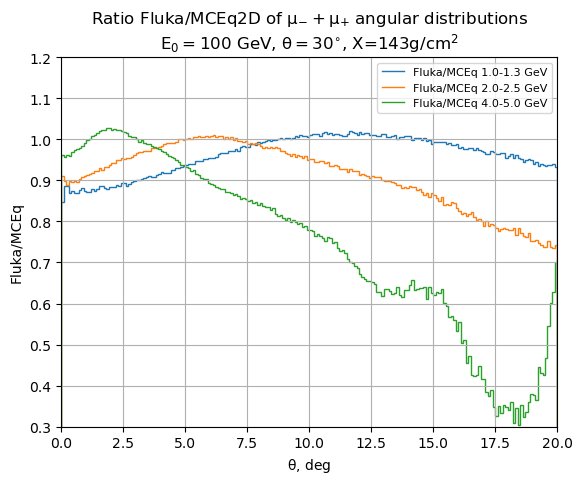

In [40]:
figure_name = f"fig12.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0.3, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

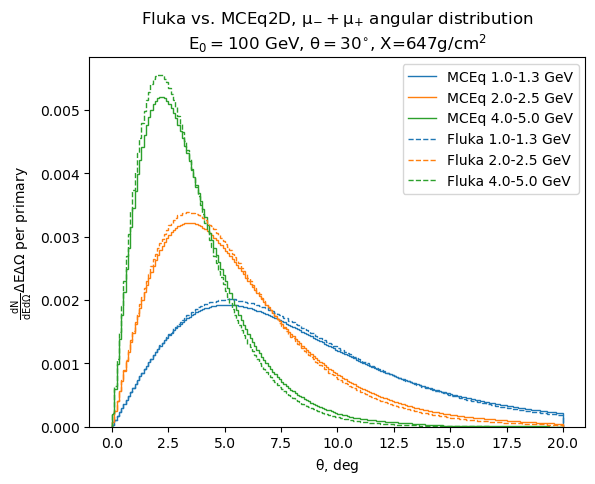

In [44]:
figure_name = f"fig13.{figure_format}"

xdepth = 647
ixdepth = 1
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

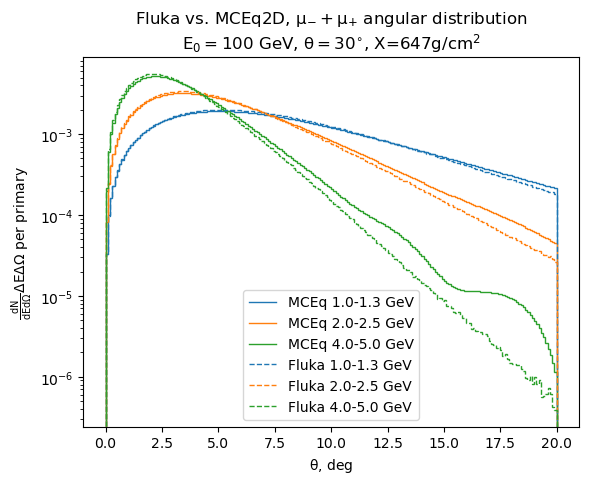

In [45]:
figure_name = f"fig14.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

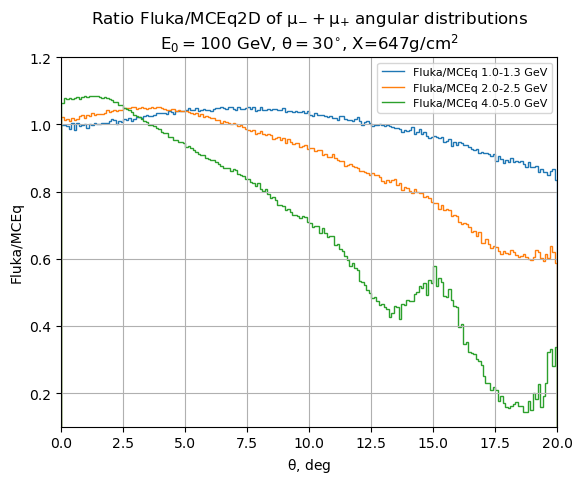

In [46]:
figure_name = "fig15"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0.1, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

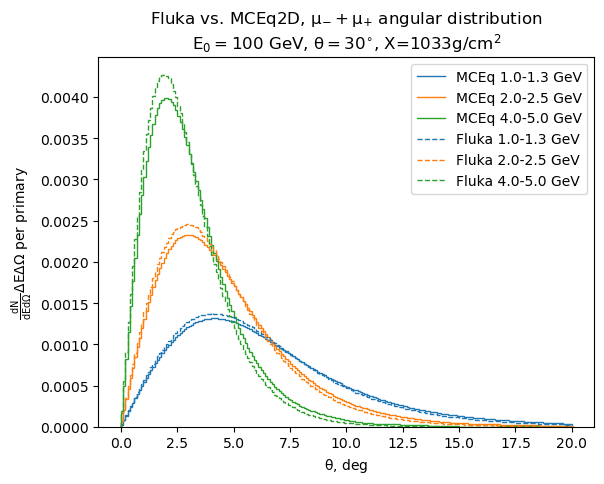

In [48]:
figure_name = "fig16"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

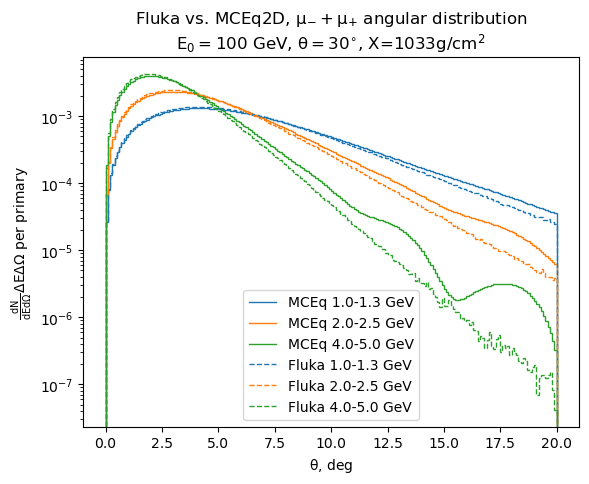

In [49]:
figure_name = "fig17"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

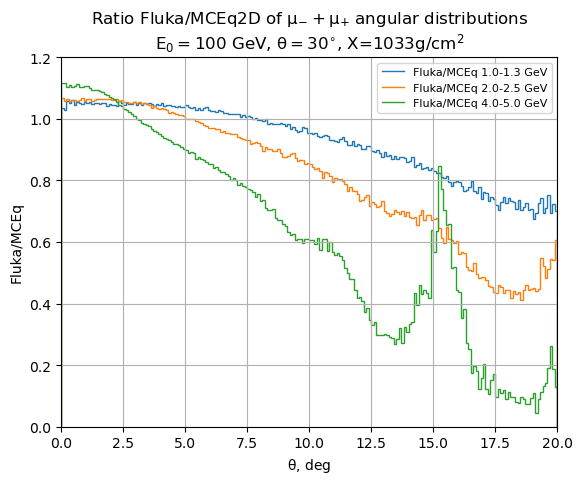

In [50]:
figure_name = "fig18"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

# Corsika vs Fluka

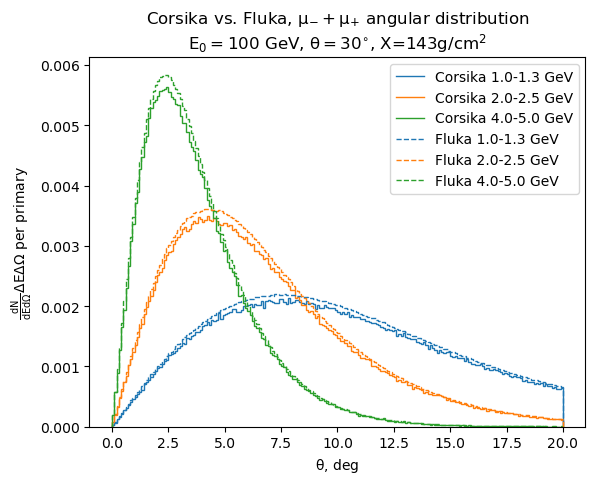

In [51]:
figure_name = "fig02_01"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

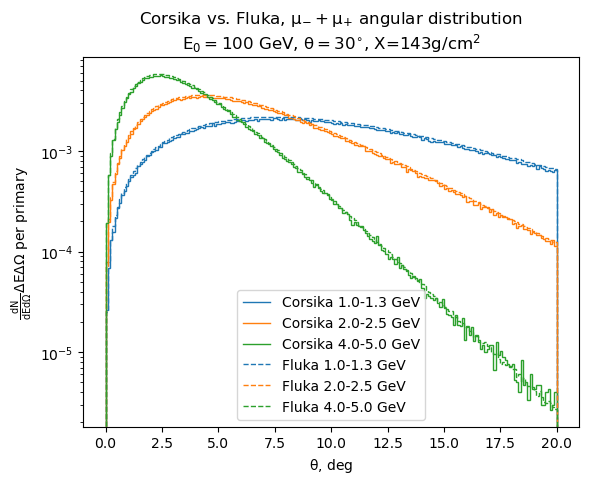

In [52]:
figure_name = "fig02_02"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

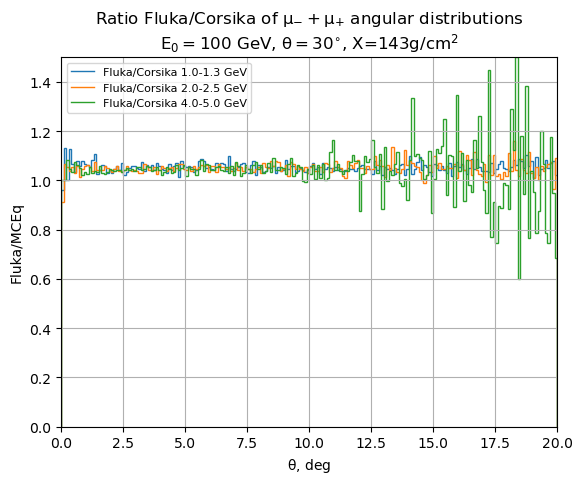

In [54]:
figure_name = "fig02_03"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

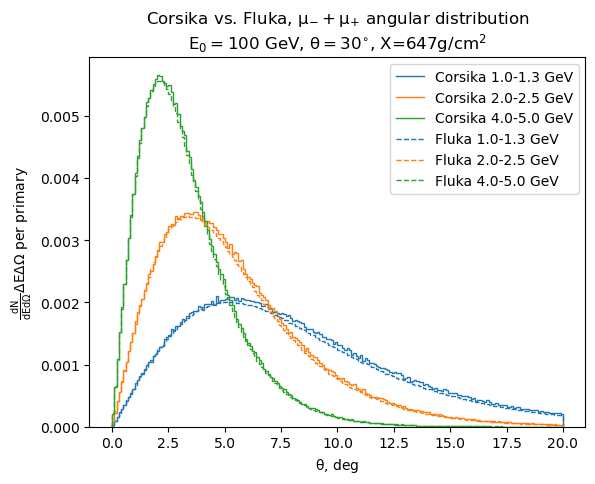

In [55]:
figure_name = "fig02_04"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

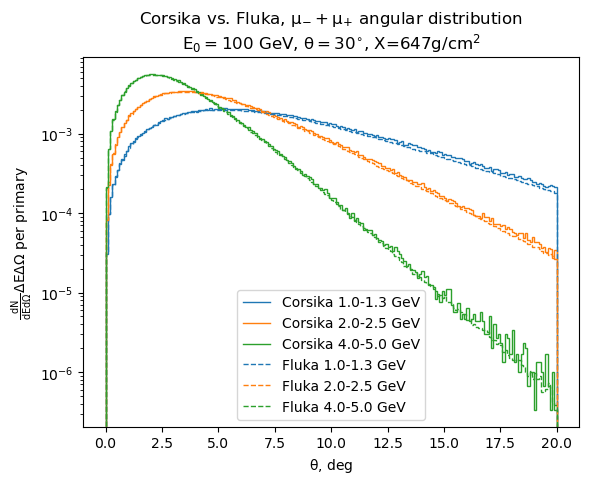

In [56]:
figure_name = "fig02_05"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

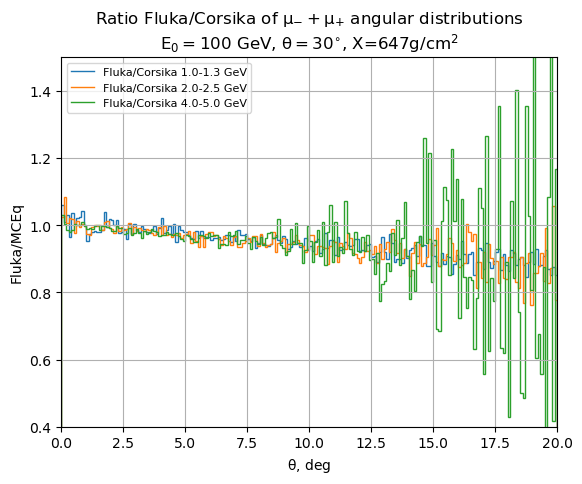

In [58]:
figure_name = "fig02_06"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0.4, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

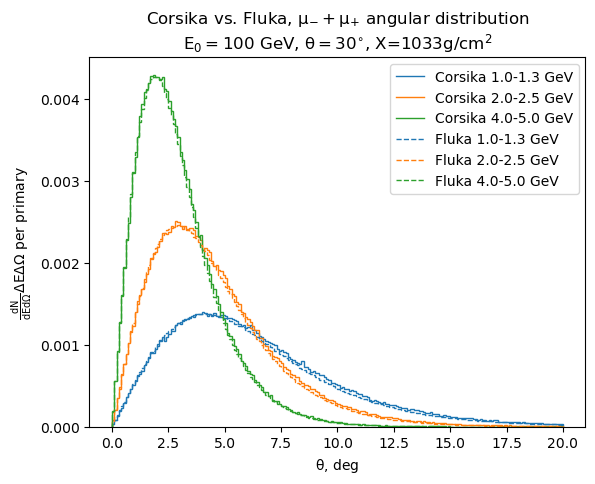

In [59]:
figure_name = "fig02_07"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

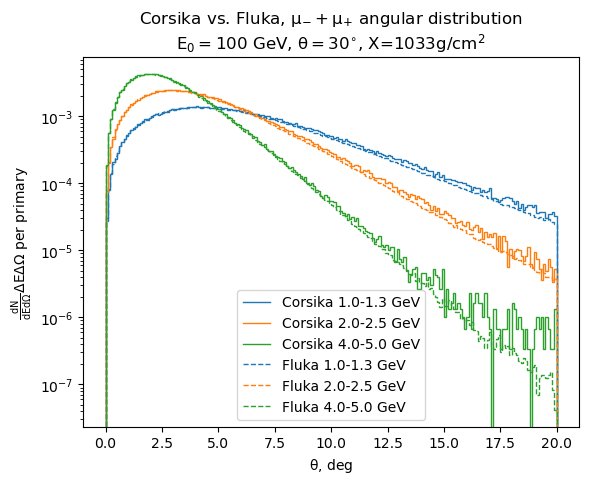

In [60]:
figure_name = "fig02_08"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

/tmp/ipykernel_531562/4013727726.py:16: RuntimeWarning: divide by zero encountered in divide
  line = plt.stairs(fl_dist[1]/crs_comb_mu[0],


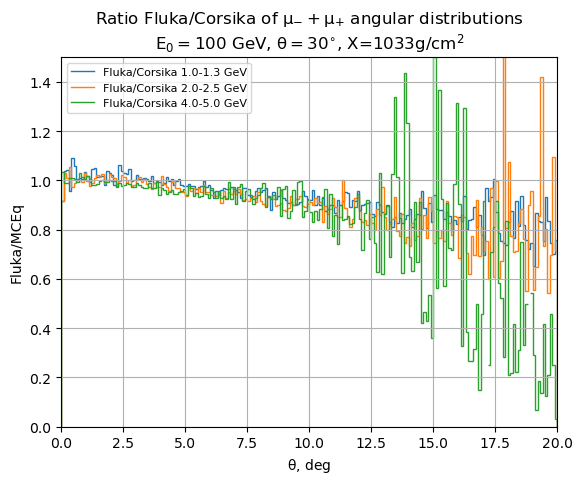

In [61]:
figure_name = "fig02_09"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

# Corsika vs MCEq with fluka bins

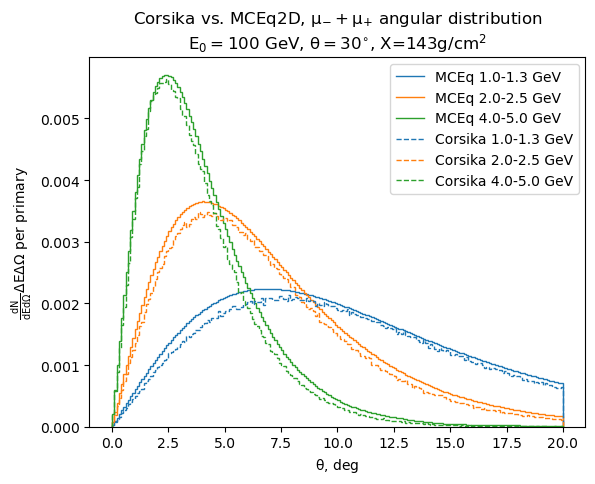

In [67]:
figure_name = "fig19"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

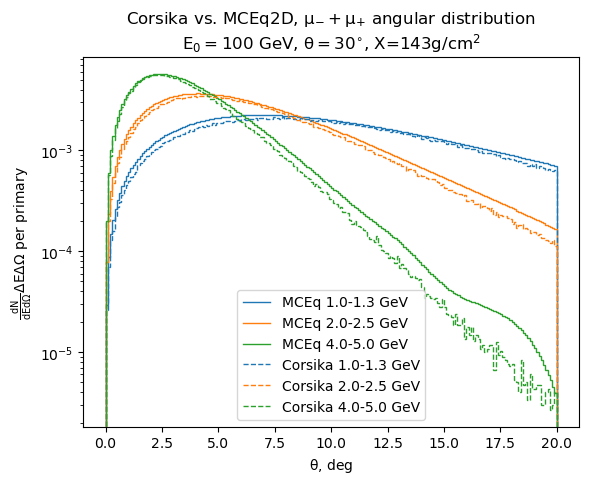

In [68]:
figure_name = "fig20"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

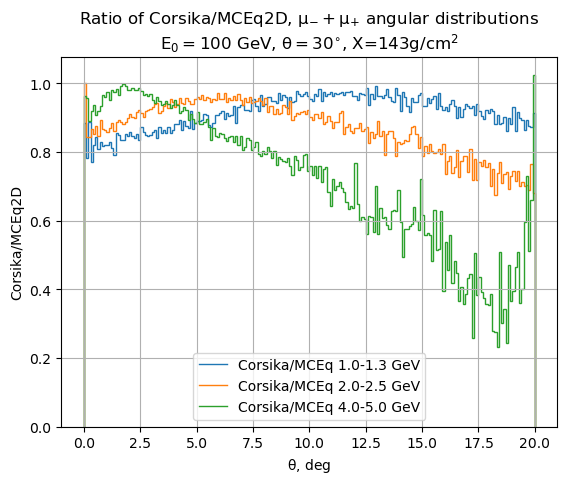

In [69]:
figure_name = "fig21"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

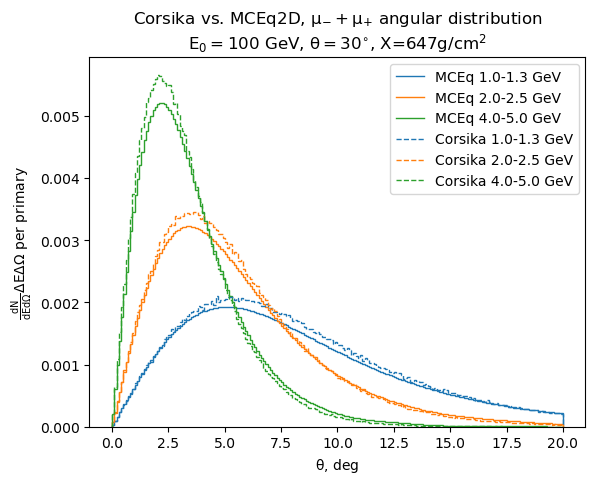

In [70]:
figure_name = "fig22"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

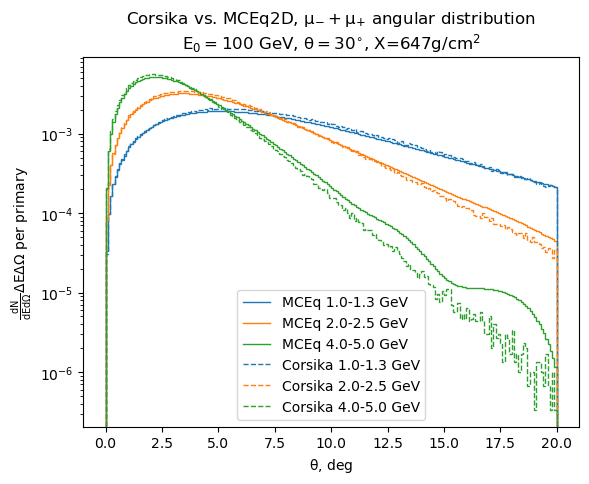

In [71]:
figure_name = "fig23"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

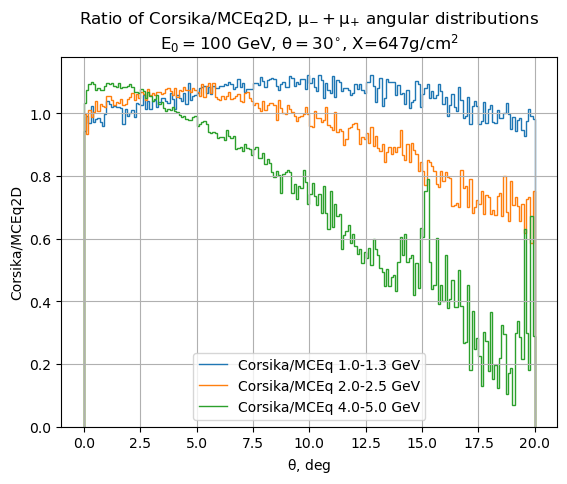

In [72]:
figure_name = "fig24"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

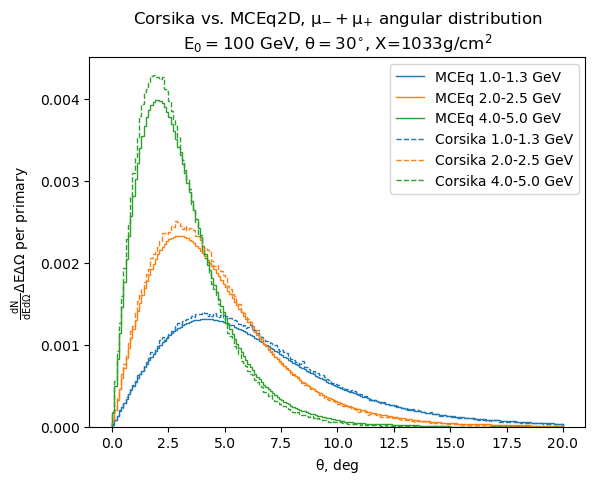

In [73]:
figure_name = "fig25"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

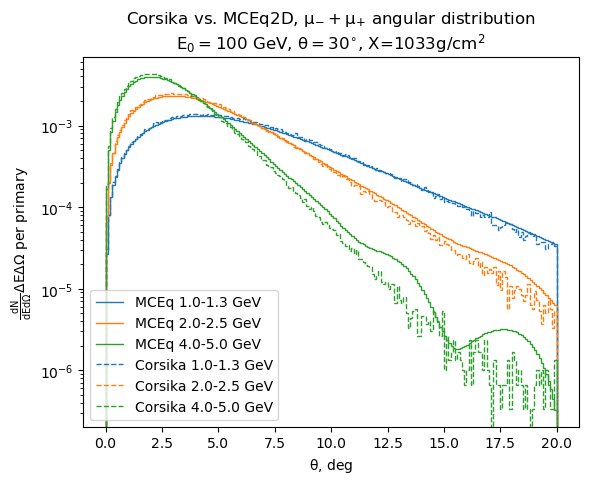

In [74]:
figure_name = "fig26"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

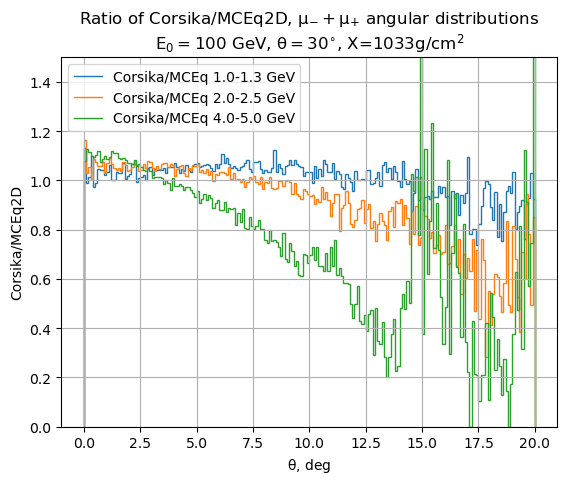

In [76]:
figure_name = "fig27"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

# Corsika vs MCEq2D

In [77]:
# Get MCEq histogram
# angle_bins = fluka_ang_bins
angle_bins = np.deg2rad(np.linspace(0, 90, 91))
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang1 = mceq_dists.histograms(energy_bins, angle_bins)

  0%|          | 0/3 [00:00<?, ?it/s]

Particle 12, slant depth = 164.945
Particle 12, slant depth = 746.679
Particle 12, slant depth = 1192.3517


 33%|███▎      | 1/3 [00:03<00:06,  3.11s/it]

Particle 13, slant depth = 164.945
Particle 13, slant depth = 746.679
Particle 13, slant depth = 1192.3517


 67%|██████▋   | 2/3 [00:05<00:02,  2.64s/it]

Particle 14, slant depth = 164.945
Particle 14, slant depth = 746.679
Particle 14, slant depth = 1192.3517


100%|██████████| 3/3 [00:08<00:00,  2.79s/it]


In [78]:
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
angle_bins = np.deg2rad(np.linspace(0, 90, 91))
corsika_en_hist1 = corsika_en_theta_2dhist(energy_bins, 
                                          angle_bins,
                                          h5file=corsika_data_file)

corsika_comb_mu1 = combined_ang_data(corsika_en_hist1, (-13, 13))
corsika_comb_nue1 = combined_ang_data(corsika_en_hist1, (-12, 12))
corsika_comb_numu1 = combined_ang_data(corsika_en_hist1, (-14, 14))

pdg = -12
xdepth=124.0, number=2.7668e+06
xdepth=552.0, number=6.6167e+06
xdepth=1036.0, number=7.3449e+06
pdg = 12
xdepth=124.0, number=3.0021e+06
xdepth=552.0, number=7.1454e+06
xdepth=1036.0, number=7.9474e+06
pdg = -13
xdepth=124.0, number=6.9842e+06
xdepth=552.0, number=5.7947e+06
xdepth=1036.0, number=3.5412e+06
pdg = 13
xdepth=124.0, number=6.2724e+06
xdepth=552.0, number=5.1226e+06
xdepth=1036.0, number=2.9921e+06
pdg = -14
xdepth=124.0, number=9.7036e+06
xdepth=552.0, number=1.8556e+07
xdepth=1036.0, number=1.9481e+07
pdg = 14
xdepth=124.0, number=1.0419e+07
xdepth=552.0, number=1.9426e+07
xdepth=1036.0, number=2.0283e+07


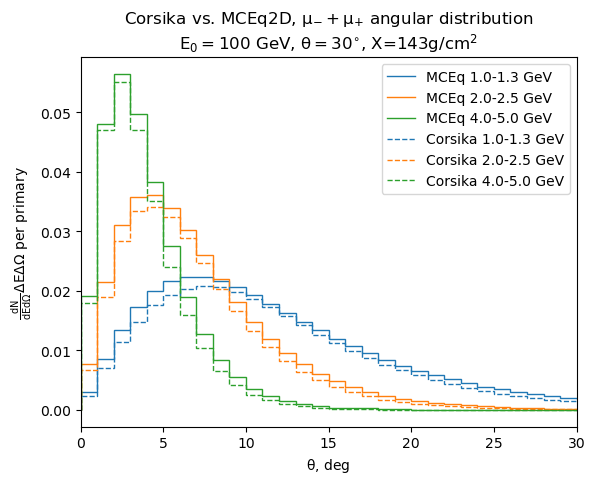

In [79]:
figure_name = "fig28"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

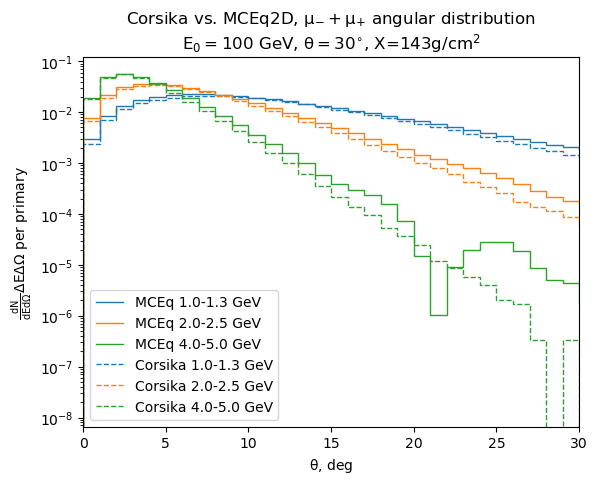

In [80]:
figure_name = "fig29"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

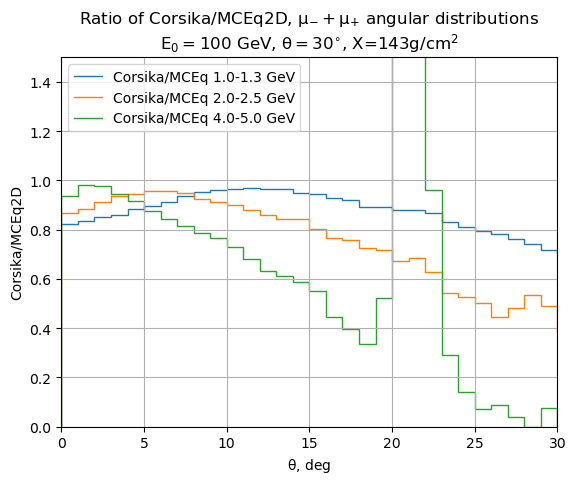

In [81]:
figure_name = "fig30"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

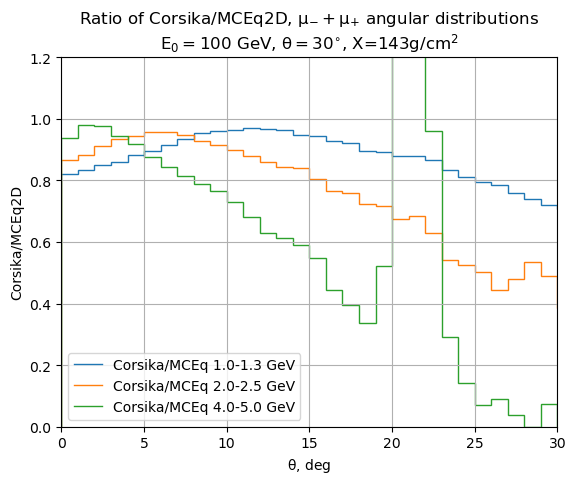

In [82]:
figure_name = "fig31"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.2)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

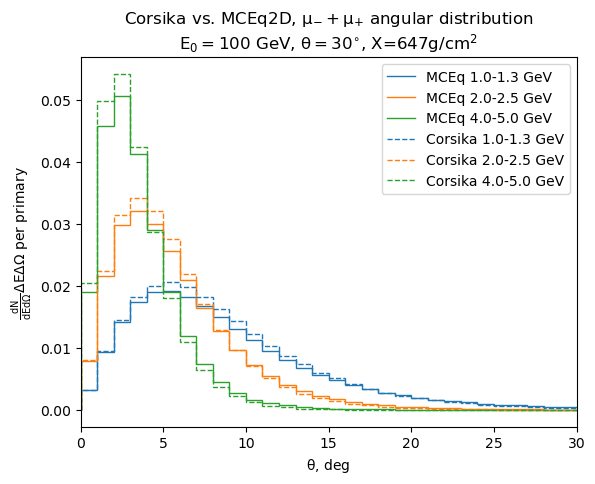

In [83]:
figure_name = "fig32"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

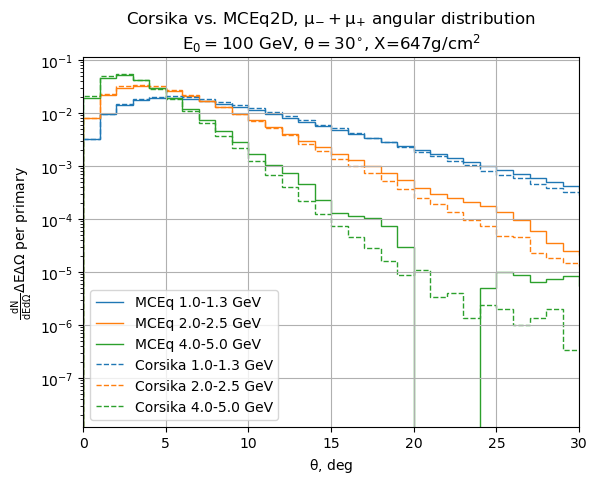

In [84]:
figure_name = "fig33"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(-1e-4, 1e-4)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)
plt.grid()

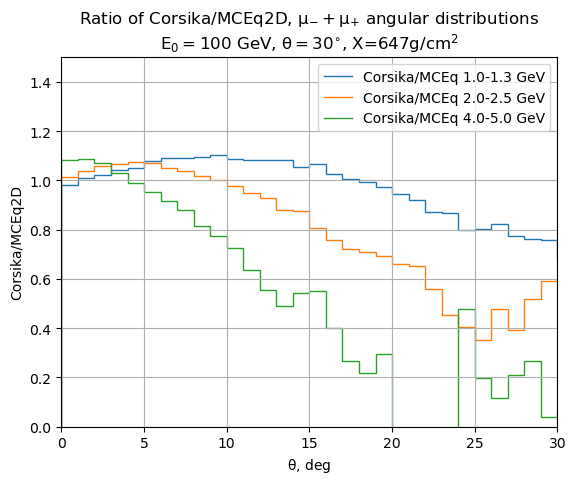

In [85]:
figure_name = "fig34"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

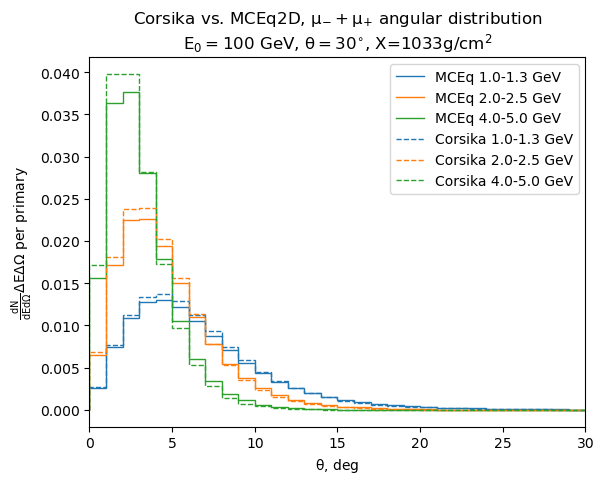

In [86]:
figure_name = "fig35"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

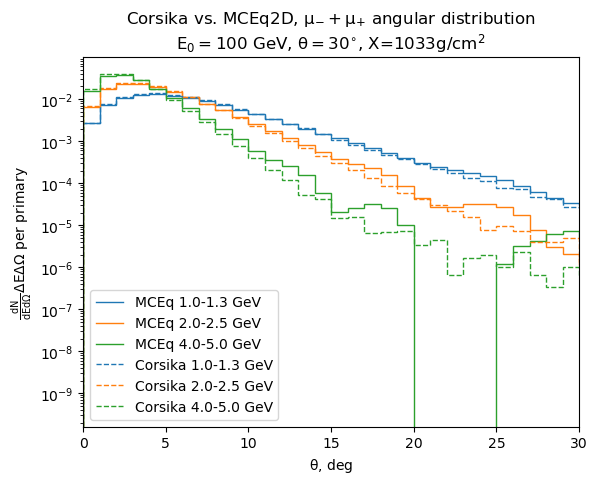

In [88]:
figure_name = "fig36"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

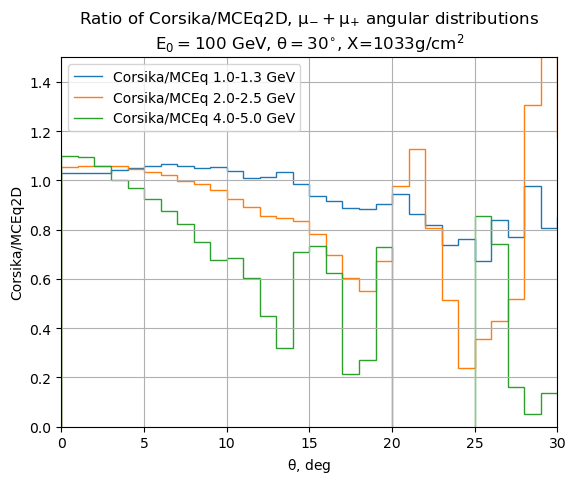

In [89]:
figure_name = "fig37"
figure_name = f"{figure_name}.{figure_format}"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][ixdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][ixdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
ixdepth = 2
ienergy = 1
plt.stairs(corsika_comb_mu[ixdepth][ienergy][0], corsika_comb_mu[ixdepth][ienergy][1])
plt.stairs(corsika_comb_mu1[ixdepth][ienergy][0], corsika_comb_mu1[ixdepth][ienergy][1])
plt.yscale("log")

In [ ]:
mceq_dists_lin = CalcMCEqHists(mceq_sol, particles = [12, 13, 14])

In [ ]:
mceq_dists_cub = CalcMCEqHists(mceq_sol, particles = [12, 13, 14])

In [ ]:
mceq_dists_cub_8000 = CalcMCEqHists(mceq_sol, particles = [12, 13, 14])

In [ ]:
mceq_dists_k5 = CalcMCEqHists(mceq_sol, particles = [12, 13, 14])

In [ ]:
angle_bins = np.deg2rad(np.linspace(0, 90, 200))
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang_lin = mceq_dists_lin.histograms(energy_bins, angle_bins)

In [ ]:
angle_bins = np.deg2rad(np.linspace(0, 90, 200))
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang_cub = mceq_dists_cub.histograms(energy_bins, angle_bins)

In [ ]:
angle_bins = np.deg2rad(np.linspace(0, 90, 200))
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang_cub_8000 = mceq_dists_cub_8000.histograms(energy_bins, angle_bins)

In [ ]:
ixdepth = 2
ienergy = 1


# plt.stairs(mceq_hists_ang_lin[13][1033]["hist_en_ang"][4], 
#            mceq_hists_ang_lin[13][1033]["ang_bins"], 
#            label = "lin")
plt.stairs(mceq_hists_ang_cub[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang_cub[13][1033]["ang_bins"],
           label = "cub")
plt.stairs(mceq_hists_ang_cub_8000[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang_cub_8000[13][1033]["ang_bins"],
           label = "cub_8000")
plt.legend()
# plt.stairs(mceq_hists_ang3[13][1033]["hist_en_ang"][4], 
#            mceq_hists_ang3[13][1033]["ang_bins"])
# plt.stairs(corsika_comb_mu1[ixdepth][ienergy][0], corsika_comb_mu1[ixdepth][ienergy][1])
# plt.yscale("log")
plt.ylim(-1e-5, 1e-5)
# plt.grid()

In [ ]:
ixdepth = 2
ienergy = 1


# plt.stairs(mceq_hists_ang_lin[13][1033]["hist_en_ang"][4], 
#            mceq_hists_ang_lin[13][1033]["ang_bins"], 
#            label = "lin")
plt.stairs(mceq_hists_ang_cub[13][1033]["hist_en_ang"][4]/mceq_hists_ang_cub_8000[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang_cub[13][1033]["ang_bins"],
           label = "cub")
# plt.stairs(mceq_hists_ang_cub_8000[13][1033]["hist_en_ang"][4], 
#            mceq_hists_ang_cub_8000[13][1033]["ang_bins"],
#            label = "cub_8000")
plt.ylim(0.99, 1.01)
plt.legend()
plt.grid()

In [ ]:
ixdepth = 2
ienergy = 1

# mceq_plt = mceq_hists_ang[13][xdepth]
#         en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
#         en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
#         line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
#                     np.rad2deg(mceq_plt["ang_bins"]),

plt.stairs(mceq_hists_ang[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang[13][1033]["ang_bins"])

plt.stairs(mceq_hists_ang1[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang1[13][1033]["ang_bins"])
# plt.stairs(corsika_comb_mu1[ixdepth][ienergy][0], corsika_comb_mu1[ixdepth][ienergy][1])
# plt.yscale("log")
plt.ylim(-1e-5, 1e-5)
plt.grid()

In [ ]:
ixdepth = 2
ienergy = 1


plt.stairs(mceq_hists_ang2[13][1033]["hist_en_ang"][4]/mceq_hists_ang3[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang2[13][1033]["ang_bins"])
# plt.stairs(mceq_hists_ang3[13][1033]["hist_en_ang"][4], 
#            mceq_hists_ang3[13][1033]["ang_bins"])
# plt.stairs(corsika_comb_mu1[ixdepth][ienergy][0], corsika_comb_mu1[ixdepth][ienergy][1])
# plt.yscale("log")
# plt.ylim(-1e-5, 1e-5)
# plt.grid()

In [ ]:
ixdepth = 2
ienergy = 1


plt.stairs(mceq_hists_ang2[13][1033]["hist_en_ang"][4], 
           mceq_hists_ang2[13][1033]["ang_bins"])
# plt.stairs(corsika_comb_mu1[ixdepth][ienergy][0], corsika_comb_mu1[ixdepth][ienergy][1])
# plt.yscale("log")
plt.ylim(-1e-5, 1e-5)
plt.grid()